In [32]:
import pandas as pd
# Importar utilidades para gestión de rutas
from cedenar_anomalies.utils.paths import (
    data_processed_dir,
    data_raw_dir,
    data_interim_dir,
    models_dir
)

In [33]:
models_dir()

PosixPath('/Users/frandak2/Documents/repos/cedenar_anomalies/models')

In [34]:
# from fcmeans import FCM

In [35]:
pd.set_option("display.max_rows", None)  # Mostrar todas las filas
pd.set_option("display.max_columns", None)  # Mostrar todas las columnas

### Se ingresa la  sabana de datos limpia

## Unir a previo a encode

In [36]:
import pandas as pd

In [13]:
df_anomaly_encoded = pd.read_csv(data_processed_dir("dataset_train_clean.csv"))

In [14]:
df_anomaly_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260800 entries, 0 to 260799
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Orden           260800 non-null  int64  
 1   Usuario         260800 non-null  int64  
 2   Ejecucion       260800 non-null  object 
 3   Codigo          256136 non-null  object 
 4   Descripcion     260800 non-null  object 
 5   Motivo          255439 non-null  object 
 6   kWh Rec         209785 non-null  float64
 7   Factor          3112 non-null    float64
 8   id              250692 non-null  float64
 9   Nombre          250692 non-null  object 
 10  Factor.1        3112 non-null    float64
 11  AREA            260789 non-null  object 
 12  PLAN_COMERCIAL  260789 non-null  object 
 13  TRAFO_OPEN      260658 non-null  object 
 14  FASES           258909 non-null  float64
 15  KVA             260557 non-null  float64
 16  LATI_USU        260557 non-null  float64
 17  LONG_USU  

In [15]:
df_anomaly_encoded.columns

Index(['Orden', 'Usuario', 'Ejecucion', 'Codigo', 'Descripcion', 'Motivo',
       'kWh Rec', 'Factor', 'id', 'Nombre', 'Factor.1', 'AREA',
       'PLAN_COMERCIAL', 'TRAFO_OPEN', 'FASES', 'KVA', 'LATI_USU', 'LONG_USU',
       'puntaje', 'evaluacion', 'Zona'],
      dtype='object')

In [16]:
columnas_deseadas = [
    "Usuario", "AREA", "PLAN_COMERCIAL", "LATI_USU", "LONG_USU",'puntaje', 'evaluacion'
]

In [17]:
df_anomaly_encoded[columnas_deseadas].sample(5)

,Usuario,AREA,PLAN_COMERCIAL,LATI_USU,LONG_USU,puntaje,evaluacion
156029,1190885,Rural,2-PLAN RESIDENCIAL,1.976874,-77.234636,5.0,3.0
128824,191408,Rural,2-PLAN RESIDENCIAL,1.380069,-77.148776,1.0,1.0
130957,139056,Urbano,2-PLAN RESIDENCIAL,1.200168,-77.248503,2.0,2.0
111388,383442,Urbano,31-PLAN RESIDENCIAL TELEMEDIDO,1.813264,-78.766314,4.0,3.0
30997,552260,Rural,2-PLAN RESIDENCIAL,1.521526,-77.052734,2.0,2.0


In [18]:
import logging
from typing import Dict, Optional
import pandas as pd
import joblib
from pathlib import Path
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score
from fcmeans import FCM
from skfda.ml.clustering import FuzzyCMeans

# Importar utilidades para gestión de rutas
from cedenar_anomalies.utils.paths import models_dir

class SklearnFCMWrapper(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=3, m=2.0, random_state=42, distance = 'euclidean', logger: Optional[logging.Logger] = None):
        self.n_clusters = n_clusters
        self.m = m
        self.random_state = random_state
        self.distance = distance
        self.logger = logger or logging.getLogger(self.__class__.__name__)

    def fit(self, X, y=None):
        self.logger.info(f"Entrenando FCM con {self.n_clusters} clusters y m={self.m}")
        self.model_ = FCM(n_clusters=self.n_clusters,
                          m=self.m,
                          random_state = self.random_state,
                          distance = self.distance)
        self.model_.fit(X)
        self.labels_ = self.model_.predict(X)
        self.centers_ = self.model_.centers
        self.u_ = self.model_.u
        self.pc_ = self.model_.partition_coefficient
        self.pec_ = self.model_.partition_entropy_coefficient
        self.logger.info("Entrenamiento FCM completo.")
        return self

    def predict(self, X):
        self.logger.info("Realizando predicción con FCM.")
        return self.model_.predict(X)

    def soft_predict(self, X):
        self.logger.info("Realizando soft predicción con FCM.")
        return self.model_.soft_predict(X)


class PipelineClusterFzz:
    def __init__(self, n_clusters=3, m=2, distance= 'euclidean', model_dir=models_dir(), scores_path="silhouette_scores.csv",  logger: Optional[logging.Logger] = None):
        self.n_clusters = n_clusters
        self.model_dir = model_dir
        self.distance = distance
        self.m = m
        self.scores_path = models_dir(f'{distance}_{scores_path}')
        self.model_dir.mkdir(parents=True, exist_ok=True)
        self.scores = []
        self.numerical_cols = ["LATI_USU", "LONG_USU"]
        self.categorical_cols = ["AREA", "PLAN_COMERCIAL"]
        self.logger = logging.getLogger(self.__class__.__name__)
        self.logger.info("Inicializando PipelineClusterFzz")

    def build_pipeline(self):
        self.logger.info("Construyendo pipeline de preprocesamiento y clustering.")

        # self.numerical_cols = ["kWh Rec", "FASES", "KVA", "LATI_USU", "LONG_USU", "puntaje", "evaluacion"]
        # self.categorical_cols = ["AREA", "PLAN_COMERCIAL"]


        numeric_pipeline = Pipeline([
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler())
        ])

        categorical_pipeline = Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("labelenc", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
        ])

        preprocessor = ColumnTransformer([
            ("num", numeric_pipeline, self.numerical_cols),
            ("cat", categorical_pipeline, self.categorical_cols)
        ])

        pipeline = Pipeline([
            ("preprocess", preprocessor),
            ("cluster", SklearnFCMWrapper(n_clusters=self.n_clusters,
                                          m=self.m,
                                          random_state=42,
                                          distance= self.distance,
                                          logger=self.logger))
            # ("cluster", FuzzyCMeans(n_clusters=self.n_clusters, random_state=42))  #m=2.0
        ])

        return pipeline

    def fit(self, df: pd.DataFrame, zona: str) -> Pipeline:
        self.logger.info(f"Iniciando entrenamiento para zona: {zona}")
        df_zone = df[df["Zona"] == zona].copy()
        pipeline = self.build_pipeline()
        pipeline.fit(df_zone)
        self.logger.info(f"Entrenamiento completado para zona: {zona}")
        return pipeline

    def predict(self, pipeline: Pipeline, df: pd.DataFrame) -> pd.DataFrame:
        self.logger.info("Iniciando predicción con pipeline entrenado.")
        df = df.copy()

        # Transformar los datos con el preprocesador
        X_transformed = pipeline.named_steps["preprocess"].transform(
            df[self.categorical_cols + self.numerical_cols]
        )

        # Obtener cluster duro
        labels = pipeline.named_steps["cluster"].predict(X_transformed)
        df["cluster_id"] = labels

        # Obtener cluster suave
        matrix_pertenencia = pipeline.named_steps["cluster"].soft_predict(X_transformed)
        cluster_columns = [f"cluster_{i}" for i in range(matrix_pertenencia.shape[1])]
        matrix_pertenencia_df = pd.DataFrame(matrix_pertenencia, columns=cluster_columns)

        # Unir con el dataframe original
        df = pd.concat([df.reset_index(drop=True), matrix_pertenencia_df.reset_index(drop=True)], axis=1)
        return df


    def train_by_zone(self, df: pd.DataFrame) -> dict:
        pipelines = {}
        silhouette_scores = []

        self.logger.info("Entrenando pipelines por zona.")
        for zona in df["Zona"].unique():
            self.logger.info(f"Procesando zona: {zona}")
            df_zone = df[df["Zona"] == zona].copy()
            pipeline = self.fit(df, zona)
            df_with_clusters = self.predict(pipeline, df_zone)

            X_transformed = pipeline.named_steps["preprocess"].transform(
                df_zone[self.categorical_cols + self.numerical_cols]
            )
            score = silhouette_score(X_transformed, df_with_clusters["cluster_id"])
            self.logger.info(f"Índice de silueta para zona {zona}: {score:.4f}")

            pc = pipeline.named_steps["cluster"].pc_
            pec = pipeline.named_steps["cluster"].pec_

            joblib.dump(pipeline, self.model_dir / f"pipeline_{zona}.pkl")
            self.logger.info(f"Pipeline guardado para zona {zona}")

            silhouette_scores.append({"zona": zona, "silhouette_score": score, "PC":pc , "PEC": pec})
            pipelines[zona] = pipeline

        pd.DataFrame(silhouette_scores).to_csv(self.scores_path, index=False)
        self.logger.info(f"Scores de silueta guardados en: {self.scores_path}")
        return pipelines

    def predict_all_zones(self, df: pd.DataFrame, pipelines: dict) -> pd.DataFrame:
        self.logger.info("Iniciando predicción en todas las zonas.")
        df_all = []
        for zona, pipeline in pipelines.items():
            self.logger.info(f"Prediciendo zona: {zona}")
            df_zone = df[df["Zona"] == zona].copy()
            df_clustered = self.predict(pipeline, df_zone)
            df_all.append(df_clustered)
        return pd.concat(df_all, ignore_index=True)

    def load_pipelines(self) -> dict:
        self.logger.info("Cargando pipelines guardados desde disco.")
        pipelines = {}
        for model_file in self.model_dir.glob("pipeline_*.pkl"):
            zona = model_file.stem.replace("pipeline_", "")
            pipelines[zona] = joblib.load(model_file)
            self.logger.info(f"Pipeline cargado para zona: {zona}")
        return pipelines


In [19]:
# Configurar logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

In [ ]:
pipe = PipelineClusterFzz(n_clusters=3, m=1.5, logger=logger)
list_pipe = pipe.train_by_zone(df=df_anomaly_encoded)

In [95]:
pipeline_pa = list_pipe["PA"]
pipeline_pa

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LATI_USU', 'LONG_USU']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('labelenc',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['AREA',
                                                   'PLAN_COMERCIAL'])])),
                ('cluster',
                 SklearnFCMWrapper(logger=<Logger PipelineClusterFzz (INFO)>,
                                   m=1.5))])

In [96]:
fcm_centers_pipe = pipeline_pa.named_steps["cluster"].centers_
fcm_labels_pipe = pipeline_pa.named_steps["cluster"].labels_
fcm_u_pipe = pipeline_pa.named_steps["cluster"].u_

In [97]:
data_pa = df_anomaly_encoded[df_anomaly_encoded.Zona=='PA']
df_selected = pipeline_pa.named_steps["preprocess"].transform(data_pa)

In [98]:
pipeline_pa.predict(data_pa)

2025-05-31 15:36:33,595 - INFO - Realizando predicción con FCM.


array([0, 1, 1, ..., 0, 0, 0])

In [99]:
pipeline_pa.named_steps["cluster"].soft_predict(df_selected)

2025-05-31 15:36:33,715 - INFO - Realizando soft predicción con FCM.


array([[9.98079683e-01, 1.22458278e-03, 6.95733928e-04],
       [2.04244252e-02, 9.75666342e-01, 3.90923293e-03],
       [2.13389002e-02, 9.74556840e-01, 4.10425953e-03],
       ...,
       [9.91016366e-01, 7.95958575e-03, 1.02404824e-03],
       [9.91016366e-01, 7.95958575e-03, 1.02404824e-03],
       [9.91016366e-01, 7.95958575e-03, 1.02404824e-03]])

In [100]:
data_pa = pipe.predict(df=data_pa.copy(), pipeline=pipeline_pa)
data_pa.head(2)

2025-05-31 15:36:33,858 - INFO - Iniciando predicción con pipeline entrenado.
2025-05-31 15:36:33,882 - INFO - Realizando predicción con FCM.
2025-05-31 15:36:33,892 - INFO - Realizando soft predicción con FCM.


,Orden,Usuario,Ejecucion,Codigo,Descripcion,Motivo,kWh Rec,Factor,id,Nombre,Factor.1,AREA,PLAN_COMERCIAL,TRAFO_OPEN,FASES,KVA,LATI_USU,LONG_USU,puntaje,evaluacion,Zona,cluster_id,cluster_0,cluster_1,cluster_2
0,10699622,1149695,2022-01-04 10:22:40-05,EEM,Posible anomalia,NaN,0.0,NaN,27.0,ELEMENTO EXTRANO DENTRO,NaN,Urbano,2-PLAN RESIDENCIAL,60TA011002,1.0,75.0,1.805776,-78.776637,5.0,3.0,PA,0,0.998080,0.001225,0.000696
1,11168065,544326,2021-03-27 08:04:44-05,30004,Anomalia verificada y aprobada,Otras Anomalias,NaN,NaN,40.0,OTRAS ANOMALÍAS REINCIDENTE PARE,NaN,Urbano,2-PLAN RESIDENCIAL,05TN000137,2.0,45.0,1.672157,-78.142107,1.0,1.0,PA,1,0.020424,0.975666,0.003909


In [101]:
data_pa["cluster_id"].value_counts()

cluster_id
0    48128
2    39399
1    26492
Name: count, dtype: int64

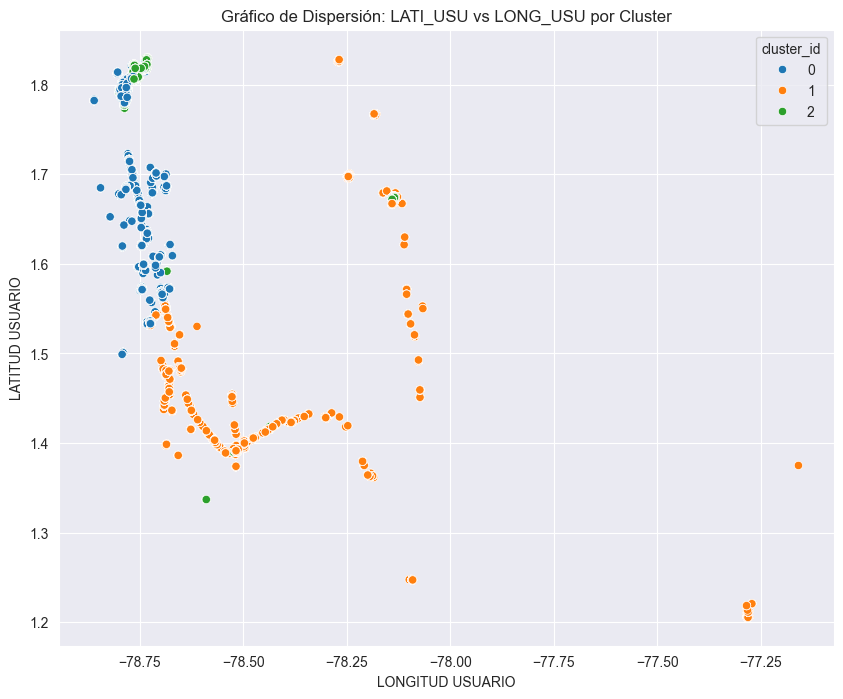

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
# Asegúrate de que 'Cluster' sea numérico o categórico
data_pa["cluster_id"] = data_pa[
    "cluster_id"
].astype(str)  # O numérico si es apropiado

# Crea el gráfico de dispersión con colores basados en 'Cluster'
plt.figure(figsize=(10, 8))  # Ajusta el tamaño de la figura si es necesario
sns.scatterplot(
    x="LONG_USU", y="LATI_USU", hue="cluster_id", data=data_pa
)

# Añade etiquetas y título
plt.title("Gráfico de Dispersión: LATI_USU vs LONG_USU por Cluster")
plt.xlabel("LONGITUD USUARIO")
plt.ylabel("LATITUD USUARIO")

# Muestra la leyenda (automática con 'hue')
plt.legend(title="cluster_id")

# Muestra el gráfico
plt.show()

In [103]:
df = df_anomaly_encoded.copy()
output_path = "dataset_con_clusters.csv"

In [104]:
try:
    pipe = PipelineClusterFzz(logger=logger)
    pipelines = pipe.load_pipelines()

    if not pipelines:
        logger.error("No se encontraron modelos entrenados para predecir.")

    df_predicted = pipe.predict_all_zones(df, pipelines)

    if df_predicted.empty:
        logger.error("La predicción no generó resultados.")

    df_predicted.to_csv(output_path, index=False)
    logger.info(f"Predicción completada y guardada en: {output_path}")

except Exception as e:
    logger.exception(f"Error durante el proceso de predicción: {e}")

2025-05-31 15:36:35,636 - INFO - Inicializando PipelineClusterFzz
2025-05-31 15:36:35,636 - INFO - Cargando pipelines guardados desde disco.
2025-05-31 15:36:35,639 - INFO - Pipeline cargado para zona: PA
2025-05-31 15:36:35,642 - INFO - Pipeline cargado para zona: OC
2025-05-31 15:36:35,645 - INFO - Pipeline cargado para zona: CE
2025-05-31 15:36:35,648 - INFO - Pipeline cargado para zona: NO
2025-05-31 15:36:35,649 - INFO - Pipeline cargado para zona: SU
2025-05-31 15:36:35,650 - INFO - Iniciando predicción en todas las zonas.
2025-05-31 15:36:35,650 - INFO - Prediciendo zona: PA
2025-05-31 15:36:35,670 - INFO - Iniciando predicción con pipeline entrenado.
2025-05-31 15:36:35,693 - INFO - Realizando predicción con FCM.
2025-05-31 15:36:35,704 - INFO - Realizando soft predicción con FCM.
2025-05-31 15:36:35,723 - INFO - Prediciendo zona: OC
2025-05-31 15:36:35,734 - INFO - Iniciando predicción con pipeline entrenado.
2025-05-31 15:36:35,740 - INFO - Realizando predicción con FCM.
2025

In [37]:
output_path = "dataset_con_clusters.csv"
df_predicted = pd.read_csv(output_path)
df_predicted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260800 entries, 0 to 260799
Data columns (total 25 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Orden           260800 non-null  int64  
 1   Usuario         260800 non-null  int64  
 2   Ejecucion       260800 non-null  object 
 3   Codigo          256136 non-null  object 
 4   Descripcion     260800 non-null  object 
 5   Motivo          255439 non-null  object 
 6   kWh Rec         209785 non-null  float64
 7   Factor          3112 non-null    float64
 8   id              250692 non-null  float64
 9   Nombre          250692 non-null  object 
 10  Factor.1        3112 non-null    float64
 11  AREA            260789 non-null  object 
 12  PLAN_COMERCIAL  260789 non-null  object 
 13  TRAFO_OPEN      260658 non-null  object 
 14  FASES           258909 non-null  float64
 15  KVA             260557 non-null  float64
 16  LATI_USU        260557 non-null  float64
 17  LONG_USU  

In [43]:
# Calculamos el percentil 95 de 'kWh Rec'
p95 = df_filtered['kWh Rec'].quantile(0.95)

# Filtramos para mantener solo los datos por debajo del percentil 95
df_filtered = df_filtered[df_filtered['kWh Rec'] <= p95]


2025-05-31 19:05:49,188 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-31 19:05:49,228 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


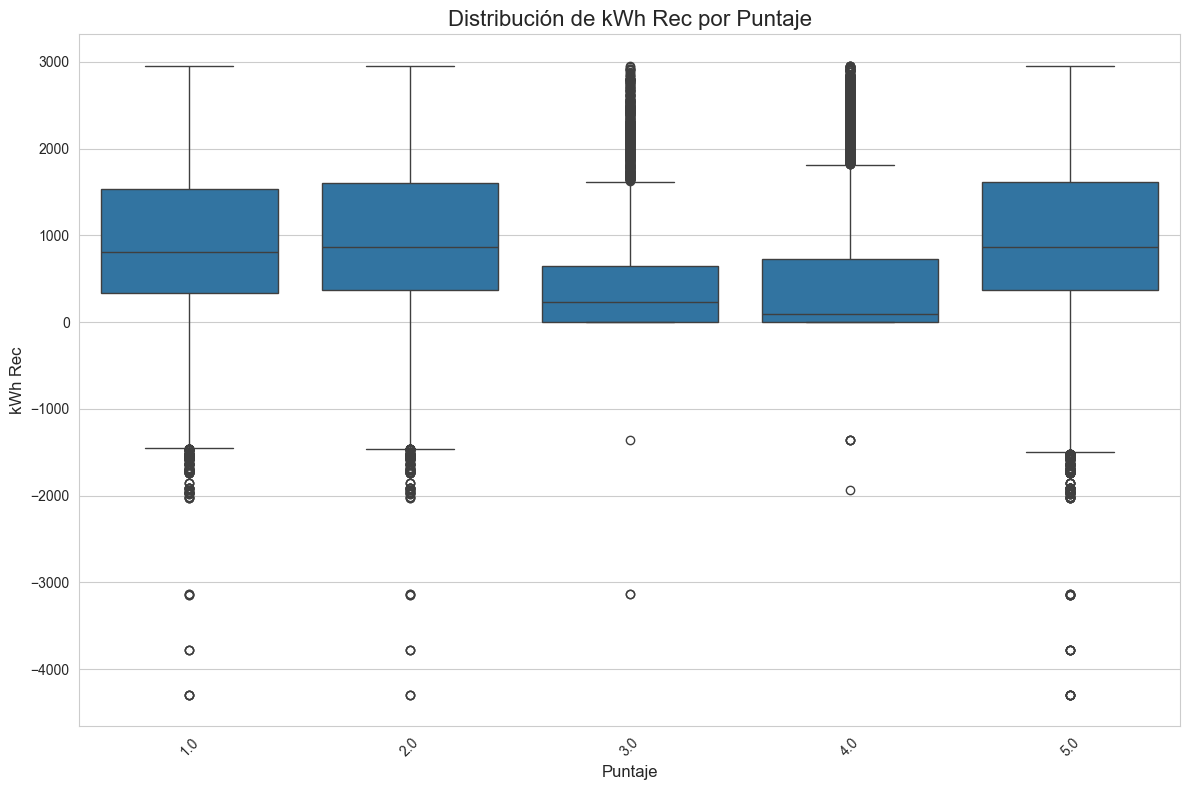

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
# Configuramos el estilo de seaborn con fondo blanco
sns.set_style("whitegrid")

import pandas as pd
import numpy as np

# Asumiendo que df_anomaly_encoded es el dataframe que contiene los datos
# Nos aseguramos de trabajar con una copia del dataframe original
df = df_filtered.copy()

# Filtramos registros que tengan valores en las columnas necesarias
df_filtered = df.dropna(subset=['kWh Rec', 'puntaje', 'Zona'])

# Creamos una figura con suficiente espacio para nuestro gráfico
plt.figure(figsize=(12, 8))

# Creamos el boxplot
# x = puntaje, y = kWh Rec, hue = Zona
sns.boxplot(x='puntaje', y='kWh Rec', data=df_filtered)

# Personalizamos el gráfico
plt.title('Distribución de kWh Rec por Puntaje', fontsize=16)
plt.xlabel('Puntaje', fontsize=12)
plt.ylabel('kWh Rec', fontsize=12)
plt.xticks(rotation=45)  # Rotamos las etiquetas del eje x para mejor visibilidad

# Mejoramos el espaciado
plt.tight_layout()

# Mostramos el gráfico
plt.show()

2025-05-31 19:06:16,157 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/Users/frandak2/Documents/repos/cedenar_anomalies/venv/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
2025-05-31 19:06:16,191 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-31 19:06:16,256 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/Users/frandak2/Documents/repos/ce

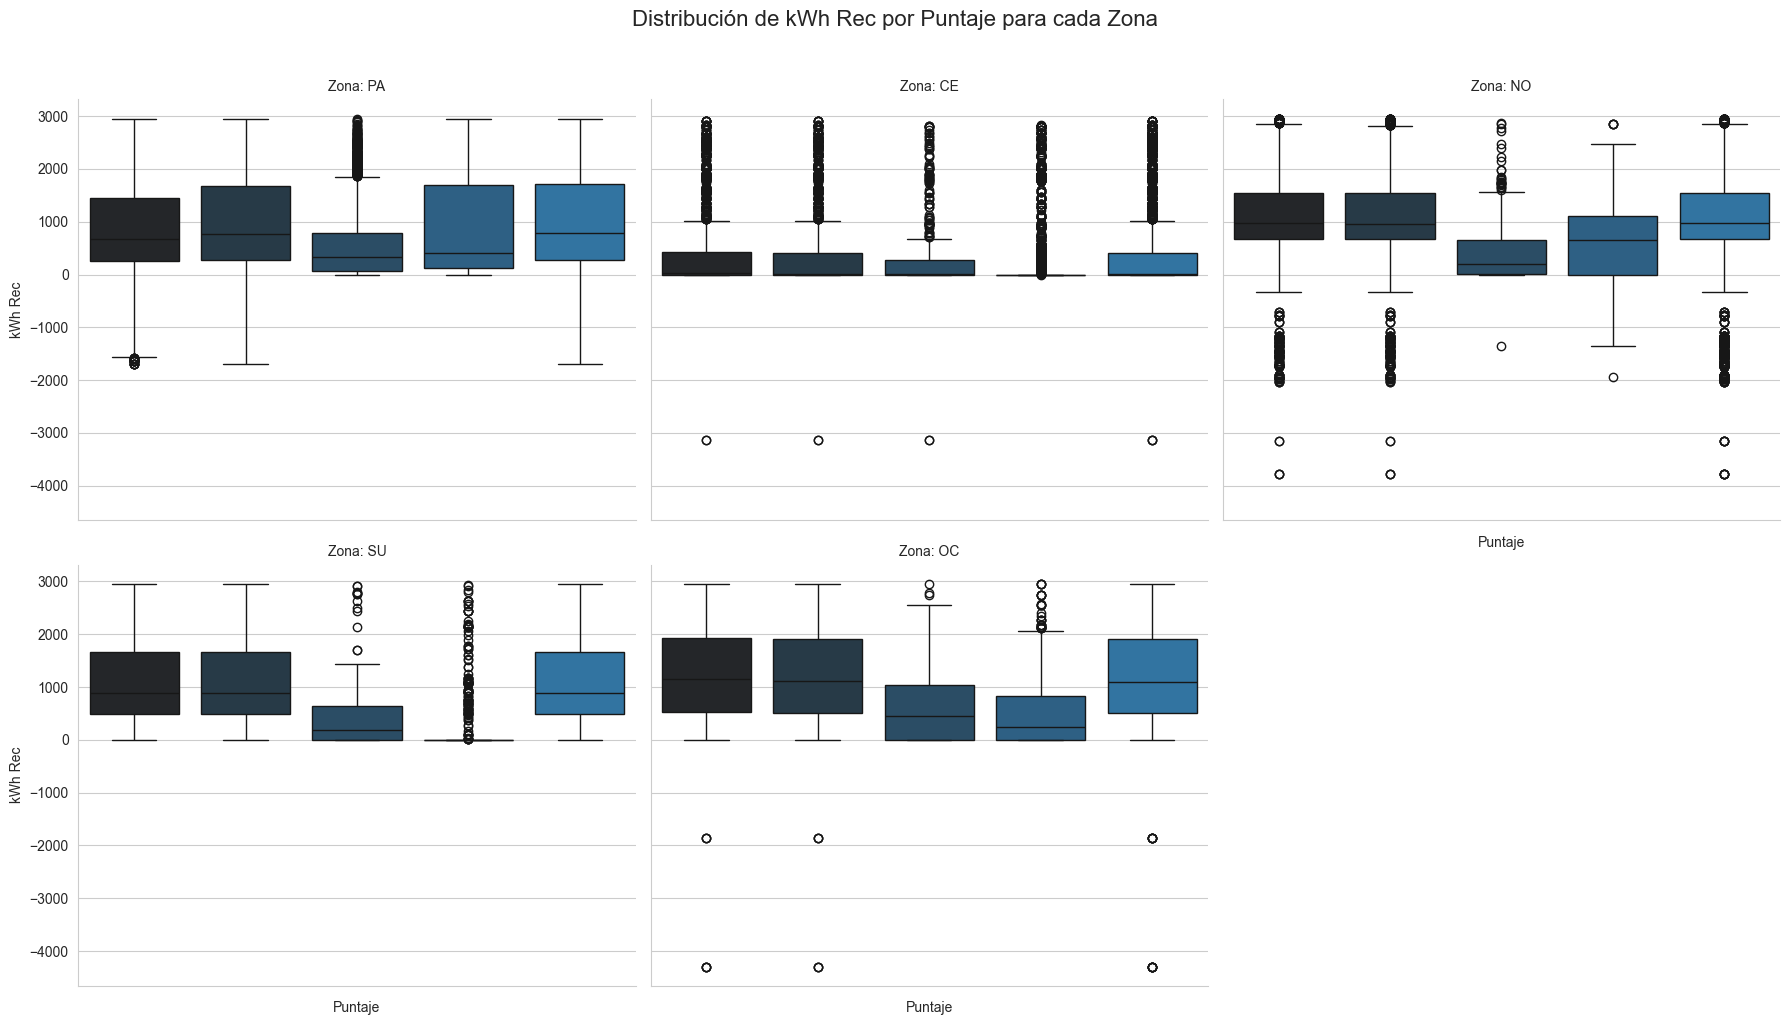

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
# Configuramos el estilo de seaborn con fondo blanco
sns.set_style("whitegrid")

import pandas as pd
import numpy as np

# Asumiendo que df_anomaly_encoded es el dataframe que contiene los datos
# Nos aseguramos de trabajar con una copia del dataframe original
df = df_filtered.copy()

# Filtramos registros que tengan valores en las columnas necesarias
df_filtered = df.dropna(subset=['kWh Rec', 'puntaje', 'Zona'])

# Creamos una FacetGrid para separar cada zona en su propio subplot
g = sns.FacetGrid(df_filtered, col="Zona", col_wrap=3, height=5, aspect=1.2)

# Mapeamos la función boxplot a cada faceta
g.map_dataframe(sns.boxplot, x="puntaje", hue='puntaje' , y="kWh Rec")

# Personalizamos los títulos y etiquetas
g.set_axis_labels("Puntaje", "kWh Rec")
g.set_titles("Zona: {col_name}")

# Rotamos las etiquetas del eje x para mejor visibilidad
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Añadimos un título general
plt.suptitle('Distribución de kWh Rec por Puntaje para cada Zona', fontsize=16, y=1.02)

# Ajustamos el espaciado
plt.tight_layout()

# Mostramos el gráfico
plt.show()

2025-05-31 19:18:50,729 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-31 19:18:50,765 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Correlación de Spearman entre puntaje (ordinal) y kWh Rec (continua): 0.0155
Valor p: 0.0000 - Estadísticamente significativa
Correlación de Kendall entre puntaje (ordinal) y kWh Rec (continua): 0.0112
Valor p: 0.0000 - Estadísticamente significativa


2025-05-31 19:18:50,852 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-31 19:18:50,885 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


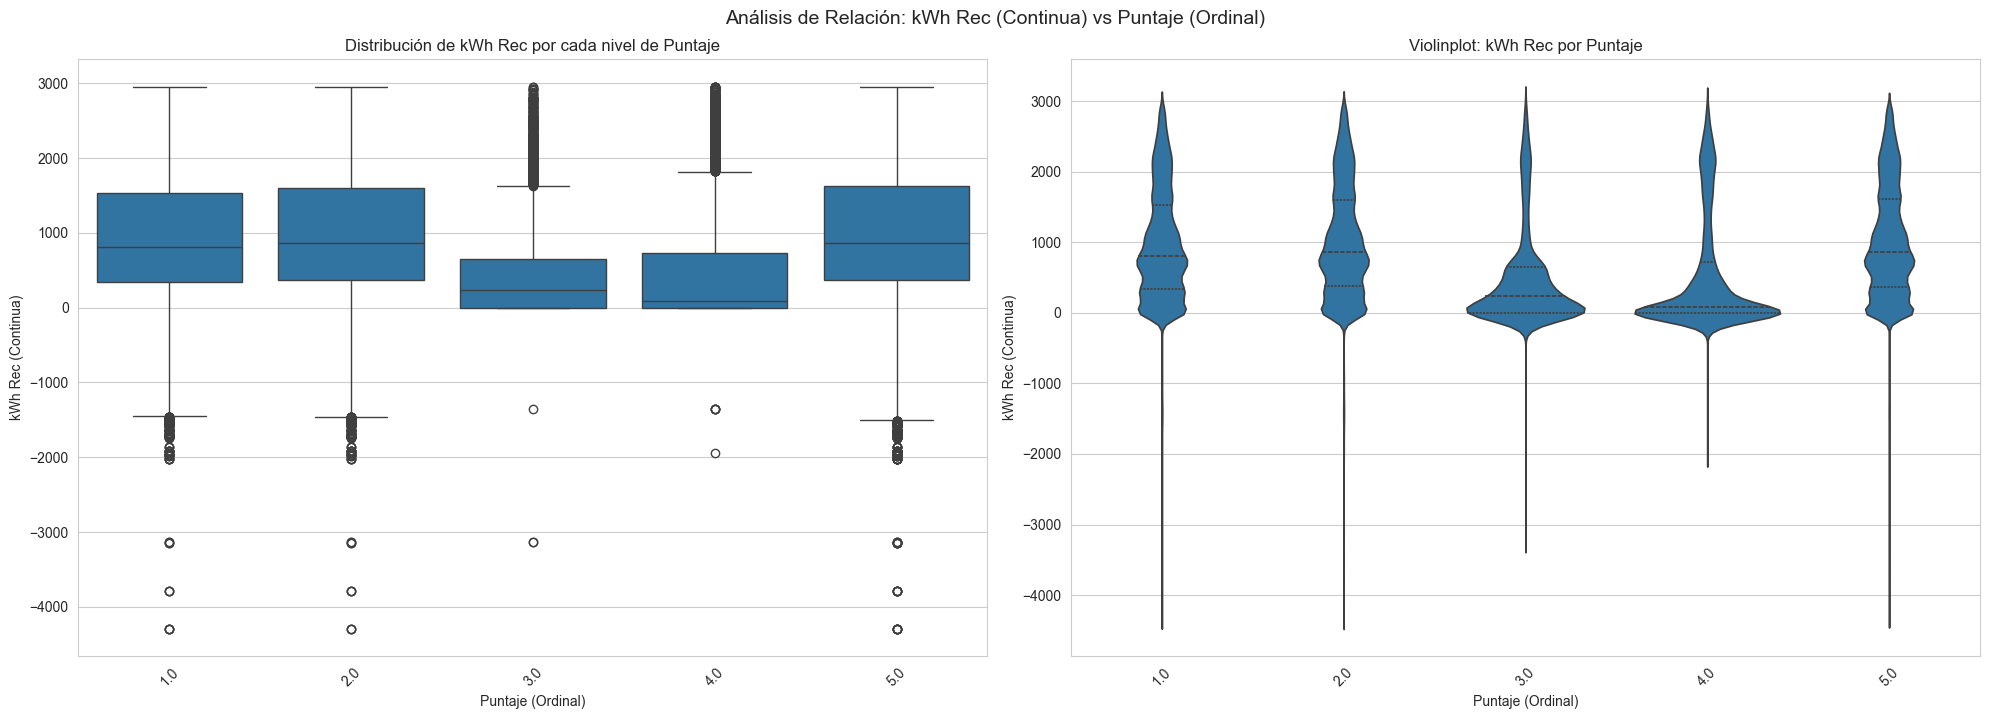

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

# Configuramos el estilo de seaborn con fondo blanco
sns.set_style("whitegrid")

# Asumiendo que df_anomaly_encoded es el dataframe que contiene los datos
# Nos aseguramos de trabajar con una copia del dataframe original
df = df_anomaly_encoded.copy()

# Filtramos registros que tengan valores en las columnas necesarias
df_filtered = df.dropna(subset=['kWh Rec', 'puntaje'])

# Calculamos el percentil 95 de 'kWh Rec' para eliminar outliers extremos
p95 = df_filtered['kWh Rec'].quantile(0.95)

# Filtramos para mantener solo los datos por debajo del percentil 95
df_filtered = df_filtered[df_filtered['kWh Rec'] <= p95]

# Para variables ordinal vs continua, la correlación de Spearman es más apropiada
spearman_corr, p_value = stats.spearmanr(df_filtered['puntaje'], df_filtered['kWh Rec'])
print(f"Correlación de Spearman entre puntaje (ordinal) y kWh Rec (continua): {spearman_corr:.4f}")
print(f"Valor p: {p_value:.4f} - {'Estadísticamente significativa' if p_value < 0.05 else 'No estadísticamente significativa'}")

# También podemos calcular la correlación de Kendall, otra medida apropiada para variables ordinales
kendall_corr, p_value_kendall = stats.kendalltau(df_filtered['puntaje'], df_filtered['kWh Rec'])
print(f"Correlación de Kendall entre puntaje (ordinal) y kWh Rec (continua): {kendall_corr:.4f}")
print(f"Valor p: {p_value_kendall:.4f} - {'Estadísticamente significativa' if p_value_kendall < 0.05 else 'No estadísticamente significativa'}")

# Creamos una figura con tres subplots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 7))

# 1. Boxplot para visualizar la distribución de kWh Rec por cada nivel de puntaje
sns.boxplot(x='puntaje', y='kWh Rec', data=df_filtered, ax=ax1)
ax1.set_title('Distribución de kWh Rec por cada nivel de Puntaje', fontsize=12)
ax1.set_xlabel('Puntaje (Ordinal)')
ax1.set_ylabel('kWh Rec (Continua)')
ax1.tick_params(axis='x', rotation=45)

# 2. Violinplot para visualizar mejor la distribución
sns.violinplot(x='puntaje', y='kWh Rec', data=df_filtered, ax=ax2, inner='quartile')
ax2.set_title('Violinplot: kWh Rec por Puntaje', fontsize=12)
ax2.set_xlabel('Puntaje (Ordinal)')
ax2.set_ylabel('kWh Rec (Continua)')
ax2.tick_params(axis='x', rotation=45)

# 3. Gráfico de correlación por Zona (usando Spearman)
zones = df_filtered['Zona'].unique()
zone_correlations = []

for zone in zones:
    zone_data = df_filtered[df_filtered['Zona'] == zone]
    if len(zone_data) > 5:  # Aseguramos que haya suficientes datos
        zone_corr, p_val = stats.spearmanr(zone_data['puntaje'], zone_data['kWh Rec'])
        significant = p_val < 0.05
        zone_correlations.append({
            'Zona': zone,
            'Correlación': zone_corr,
            'Significativa': significant
        })

# Añadimos una leyenda personalizada
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#67a9cf', edgecolor='black', label='No significativa p≥0.05'),
    Patch(facecolor='#ef8a62', edgecolor='black', label='Significativa p<0.05')
]

# Ajustamos el layout
plt.tight_layout()
plt.suptitle(f'Análisis de Relación: kWh Rec (Continua) vs Puntaje (Ordinal)',
             fontsize=14, y=1.02)

# Mostramos el gráfico
plt.show()

# implenetacion del KNN

In [23]:
columnas_deseadas = [
   "id","Nombre","AREA", "PLAN_COMERCIAL", "LATI_USU", "LONG_USU","cluster_id",'puntaje','Zona'
]

In [24]:
df_predicted[columnas_deseadas].isna().sum() / len(df_predicted)

id                0.038758
Nombre            0.038758
AREA              0.000042
PLAN_COMERCIAL    0.000042
LATI_USU          0.000932
LONG_USU          0.000932
cluster_id        0.000000
puntaje           0.038758
Zona              0.000000
dtype: float64

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Asumiendo que df_predicted es tu DataFrame con los resultados del FCM
# df_predicted = pd.read_csv('tu_archivo_con_clusters_y_puntaje.csv') # O como lo tengas cargado

# 0. Limpieza inicial del target y features clave
# KNN no puede manejar NaNs en el target.
df_knn = df_predicted[columnas_deseadas].dropna(subset=['puntaje'])

# Primero, asegúrate de que no haya NaNs en las columnas que usarás para estratificar,
# ya que train_test_split no maneja NaNs en el argumento 'stratify'.
df_knn_stratify = df_knn.dropna(subset=['puntaje', 'Zona'])

# Crea la columna combinada para la estratificación
# Convertir a string para asegurar que la concatenación funcione bien
df_knn_stratify['puntaje_zona_stratify'] = df_knn_stratify['puntaje'].astype(str) + "_" + df_knn_stratify['Zona'].astype(str)
# Verificar la distribución de esta nueva columna
logger.info("Distribución de la columna de estratificación combinada:")
logger.info(df_knn_stratify['puntaje_zona_stratify'].value_counts(normalize=True) * 100)

# Definir tus features (X) y target (y) desde el DataFrame filtrado df_knn_stratify
df_knn_stratify['cluster_id'] = df_knn_stratify['cluster_id'].astype(str)
feature_cols = ['LATI_USU', 'LONG_USU', 'AREA', 'PLAN_COMERCIAL', 'cluster_id'] # Las que usará KNN
target_col = 'puntaje'

X = df_knn_stratify[feature_cols]
y = df_knn_stratify[target_col].astype(int) # El target para KNN
stratify_col = df_knn_stratify['puntaje_zona_stratify']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,       # 80% entrenamiento, 20% prueba
    random_state=42,      # Para reproducibilidad
    stratify=stratify_col # ¡Aquí se usa la columna combinada!
)

logger.info(f"\nTamaño del conjunto de entrenamiento (X_train): {X_train.shape}")
logger.info(f"Tamaño del conjunto de prueba (X_test): {X_test.shape}")

# Puedes verificar la estratificación (opcional pero recomendado)
logger.info("\nDistribución del target 'puntaje' en el conjunto de entrenamiento:")
logger.info(y_train.value_counts(normalize=True) * 100)
logger.info("\nDistribución del target 'puntaje' en el conjunto de prueba:")
logger.info(y_test.value_counts(normalize=True) * 100)


2025-05-31 17:25:30,668 - INFO - Distribución de la columna de estratificación combinada:
2025-05-31 17:25:30,675 - INFO - puntaje_zona_stratify
5.0_PA    19.501620
5.0_NO    14.845707
1.0_PA    11.665709
2.0_PA    10.333397
1.0_NO     8.132689
2.0_NO     7.773682
5.0_OC     3.301262
5.0_CE     2.818199
5.0_SU     2.811019
4.0_PA     2.808227
4.0_CE     2.347502
1.0_CE     2.344311
1.0_OC     1.838910
2.0_OC     1.700493
1.0_SU     1.566863
2.0_SU     1.466341
2.0_CE     1.349066
3.0_PA     0.971710
3.0_CE     0.968918
4.0_SU     0.388525
4.0_NO     0.368181
3.0_NO     0.338264
3.0_SU     0.149586
4.0_OC     0.138018
3.0_OC     0.071801
Name: proportion, dtype: float64
2025-05-31 17:25:30,797 - INFO - 
Tamaño del conjunto de entrenamiento (X_train): (200553, 5)
2025-05-31 17:25:30,797 - INFO - Tamaño del conjunto de prueba (X_test): (50139, 5)
2025-05-31 17:25:30,798 - INFO - 
Distribución del target 'puntaje' en el conjunto de entrenamiento:
2025-05-31 17:25:30,799 - INFO - puntaje
5 

In [27]:
# Para verificar la estratificación por la columna combinada:
# Necesitaríamos pasar stratify_col también, pero y_train/y_test solo es el target.
# Una forma es verificar las proporciones en el 'df_knn_stratify' original vs. los índices de train/test.
# O más simple, verifica las proporciones de 'Zona' y 'puntaje' por separado en X_train/y_train y X_test/y_test.
# Por ejemplo, para 'Zona' (asumiendo que 'Zona' está en X_train y X_test si no fue la única para estratificar)
# Necesitaríamos unir temporalmente 'Zona' de vuelta o estratificar sobre un y que contenga ambas.
# La forma más directa con stratify_col es verificar sus proporciones:
_, _, stratify_train, stratify_test = train_test_split(
    X, stratify_col, test_size=0.20, random_state=42, stratify=stratify_col
)
logger.info("\nDistribución de 'puntaje_zona_stratify' en el conjunto de entrenamiento:")
logger.info(stratify_train.value_counts(normalize=True) * 100)
logger.info("\nDistribución de 'puntaje_zona_stratify' en el conjunto de prueba:")
logger.info(stratify_test.value_counts(normalize=True) * 100)

2025-05-31 17:25:39,802 - INFO - 
Distribución de 'puntaje_zona_stratify' en el conjunto de entrenamiento:
2025-05-31 17:25:39,808 - INFO - puntaje_zona_stratify
5.0_PA    19.501578
5.0_NO    14.845951
1.0_PA    11.665744
2.0_PA    10.333428
1.0_NO     8.132514
2.0_NO     7.773506
5.0_OC     3.301372
5.0_CE     2.818208
5.0_SU     2.811227
4.0_PA     2.808235
4.0_CE     2.347509
1.0_CE     2.344517
1.0_OC     1.838915
2.0_OC     1.700299
1.0_SU     1.566668
2.0_SU     1.466445
2.0_CE     1.349269
3.0_PA     0.971813
3.0_CE     0.968821
4.0_SU     0.388426
4.0_NO     0.367983
3.0_NO     0.338065
3.0_SU     0.149586
4.0_OC     0.138118
3.0_OC     0.071801
Name: proportion, dtype: float64
2025-05-31 17:25:39,808 - INFO - 
Distribución de 'puntaje_zona_stratify' en el conjunto de prueba:
2025-05-31 17:25:39,811 - INFO - puntaje_zona_stratify
5.0_PA    19.501785
5.0_NO    14.844732
1.0_PA    11.665570
2.0_PA    10.333273
1.0_NO     8.133389
2.0_NO     7.774387
5.0_OC     3.300824
5.0_CE    

In [28]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Definir columnas numéricas y categóricas PARA KNN
numerical_features_knn = ['LATI_USU', 'LONG_USU']
categorical_features_knn = ['AREA', 'PLAN_COMERCIAL', 'cluster_id']

# Crear transformadores
numeric_transformer_knn = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")), # O median, más robusto a outliers
    ("scaler", StandardScaler())
])

# Para las categóricas en KNN:
# OrdinalEncoder asigna un entero a cada categoría. Esto puede introducir un orden artificial
# que no existe (ej: Urbano=0, Rural=1 implica que Rural > Urbano).
# OneHotEncoder es generalmente mejor para KNN porque crea nuevas columnas binarias
# y evita este problema de ordenamiento. Sin embargo, puede aumentar mucho la dimensionalidad
# si hay muchas categorías únicas.
# Vamos a usar OrdinalEncoder por consistencia con tu pipeline anterior, pero considera OneHotEncoder.
categorical_transformer_knn = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")), # O una constante como 'Desconocido'
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)) # sparse_output=False si KNN no lo maneja bien directamente
])

# Combinar transformadores usando ColumnTransformer
preprocessor_knn = ColumnTransformer([
    ("num", numeric_transformer_knn, numerical_features_knn),
    ("cat", categorical_transformer_knn, categorical_features_knn)
])


# Elegir un valor para K (número de vecinos)
# Este es un hiperparámetro importante. Puedes usar validación cruzada para encontrar el óptimo.
# Empecemos con un valor común, por ejemplo K=5 o K=7.
# Usar un K impar ayuda a romper empates en clasificación binaria, aunque para multiclase
# y predict_proba, el manejo de empates es interno.
k_neighbors = 5

# Crear el pipeline completo con KNN
knn_pipeline = Pipeline([
    ("preprocess", preprocessor_knn),
    ("classifier", KNeighborsClassifier(n_neighbors=k_neighbors,
                                        weights='distance', # O 'uniform'. 'distance' da más peso a vecinos cercanos.
                                        metric='minkowski', p=2)) # p=2 es distancia Euclídea, p=1 es Manhattan
])

# Entrenar el modelo KNN (usando todos los datos disponibles X, y para este ejemplo)
logger.info("Entrenando el modelo KNN...")
knn_pipeline.fit(X_train, y_train)
# Y luego podrías evaluar:
accuracy = knn_pipeline.score(X_test, y_test)
logger.info(f"Accuracy en el conjunto de prueba: {accuracy:.4f}")
from sklearn.metrics import classification_report
y_pred_test = knn_pipeline.predict(X_test)
logger.info(classification_report(y_test, y_pred_test))

2025-05-31 17:25:43,095 - INFO - Entrenando el modelo KNN...
2025-05-31 17:25:45,567 - INFO - Accuracy en el conjunto de prueba: 0.2640
2025-05-31 17:25:47,884 - INFO -               precision    recall  f1-score   support

           1       0.20      0.25      0.22     12810
           2       0.14      0.11      0.12     11343
           3       0.43      0.15      0.22      1254
           4       0.36      0.31      0.33      3034
           5       0.36      0.35      0.35     21698

    accuracy                           0.26     50139
   macro avg       0.30      0.23      0.25     50139
weighted avg       0.27      0.26      0.26     50139



In [113]:
# Definir el espacio de búsqueda para K
param_grid = {'classifier__n_neighbors': np.arange(3, 51, 2)} # K de 3 a 49, impares

# Usar StratifiedKFold para la validación cruzada
# Aquí estratificamos por y_train (el puntaje) dentro de la validación cruzada.
# Si quisieras estratificar por 'puntaje_zona_stratify' dentro de CV, necesitarías pasar
# la columna 'puntaje_zona_stratify' correspondiente a X_train al método .split() de skf.
# Por simplicidad, estratificar CV por el target 'puntaje' suele ser suficiente si ya hiciste el split inicial bien.
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    knn_pipeline,
    param_grid,
    cv=cv_stratified, # Usar la CV estratificada
    scoring='roc_auc_ovr_weighted', # O 'f1_weighted', 'roc_auc_ovr_weighted', etc.
    verbose=1,
    n_jobs=-1
)

# Entrenar usando X_train, y_train
grid_search.fit(X_train, y_train)

print(f"Mejor K encontrado: {grid_search.best_params_['classifier__n_neighbors']}")
print(f"Mejor score de CV (Roc-auc): {grid_search.best_score_:.4f}")

# Evaluar el mejor modelo en el conjunto de prueba X_test, y_test
best_knn_model = grid_search.best_estimator_
test_accuracy = best_knn_model.score(X_test, y_test)
print(f"Accuracy en el conjunto de prueba: {test_accuracy:.4f}")

from sklearn.metrics import classification_report
y_pred_test = best_knn_model.predict(X_test)
print("\nReporte de clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_pred_test, target_names=[f"Puntaje {p}" for p in sorted(y.unique())]))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


Exception ignored in: <function ResourceTracker.__del__ at 0x11081c220>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes


Mejor K encontrado: 3
Mejor score de CV (Roc-auc): 0.4689
Accuracy en el conjunto de prueba: 0.2750

Reporte de clasificación en el conjunto de prueba:
              precision    recall  f1-score   support

   Puntaje 1       0.22      0.35      0.27     12810
   Puntaje 2       0.14      0.09      0.11     11343
   Puntaje 3       0.24      0.15      0.18      1254
   Puntaje 4       0.40      0.21      0.27      3034
   Puntaje 5       0.38      0.34      0.36     21698

    accuracy                           0.27     50139
   macro avg       0.27      0.23      0.24     50139
weighted avg       0.28      0.27      0.27     50139



In [29]:
best_knn_model = knn_pipeline
# best_knn_model = grid_search.best_estimator_

best_knn_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LATI_USU', 'LONG_USU']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['AREA', 'PLAN_COMERCIAL',
                                                   'cluster_id'])])),
                ('classifier', KNeighborsClassifier(weights='distance'))])

In [31]:
y_proba_train

array([[0.4       , 0.2       , 0.        , 0.2       , 0.2       ],
       [0.        , 0.4       , 0.        , 0.4       , 0.2       ],
       [0.8       , 0.        , 0.        , 0.        , 0.2       ],
       ...,
       [0.6       , 0.2       , 0.        , 0.        , 0.2       ],
       [0.6       , 0.4       , 0.        , 0.        , 0.        ],
       [0.24988635, 0.24988635, 0.        , 0.        , 0.5002273 ]])

In [30]:
from sklearn.metrics import roc_auc_score

# Obtener las probabilidades predichas para el conjunto de prueba
y_proba_train = best_knn_model.predict_proba(X_train)
y_proba_test = best_knn_model.predict_proba(X_test)

# Calcular ROC-AUC OvR ponderado
# Nota: y_test debe estar en su formato original, y_proba_test son las probabilidades
roc_auc_test_weighted = roc_auc_score(y_test, y_proba_test, multi_class='ovr', average='weighted')
print(f"ROC-AUC (OvR Ponderado) en Test: {roc_auc_test_weighted:.4f}")

# Calcular ROC-AUC para cada clase (One-vs-Rest)
print("\nROC-AUC por clase (OvR) en Test:")
for i, class_label in enumerate(best_knn_model.classes_):
    # Necesitas binarizar y_test para cada clase
    y_test_binarized = (y_test == class_label).astype(int)
    roc_auc_class = roc_auc_score(y_test_binarized, y_proba_test[:, i])
    print(f"  Puntaje {class_label}: {roc_auc_class:.4f}")

ROC-AUC (OvR Ponderado) en Test: 0.4488

ROC-AUC por clase (OvR) en Test:
  Puntaje 1: 0.4257
  Puntaje 2: 0.4006
  Puntaje 3: 0.6028
  Puntaje 4: 0.7660
  Puntaje 5: 0.4345


In [121]:
from sklearn.metrics import roc_auc_score

# Obtener las probabilidades predichas para el conjunto de prueba
y_proba_train = best_knn_model.predict_proba(X_train)
y_proba_test = best_knn_model.predict_proba(X_test)


# Calcular ROC-AUC OvR ponderado
# Nota: y_test debe estar en su formato original, y_proba_test son las probabilidades
roc_auc_test_weighted = roc_auc_score(y_test, y_proba_test, multi_class='ovr', average='weighted')
print(f"ROC-AUC (OvR Ponderado) en Test: {roc_auc_test_weighted:.4f}")

# Calcular ROC-AUC para cada clase (One-vs-Rest)
print("\nROC-AUC por clase (OvR) en Test:")
for i, class_label in enumerate(best_knn_model.classes_):
    # Necesitas binarizar y_test para cada clase
    y_test_binarized = (y_test == class_label).astype(int)
    roc_auc_class = roc_auc_score(y_test_binarized, y_proba_test[:, i])
    print(f"  Puntaje {class_label}: {roc_auc_class:.4f}")

ROC-AUC (OvR Ponderado) en Test: 0.4488

ROC-AUC por clase (OvR) en Test:
  Puntaje 1: 0.4257
  Puntaje 2: 0.4006
  Puntaje 3: 0.6028
  Puntaje 4: 0.7660
  Puntaje 5: 0.4345


/var/folders/pq/cm_j30pd6d5gvwryc4gttm2h0000gn/T/ipykernel_44557/1055727611.py:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', n_classes) # O cualquier otro colormap


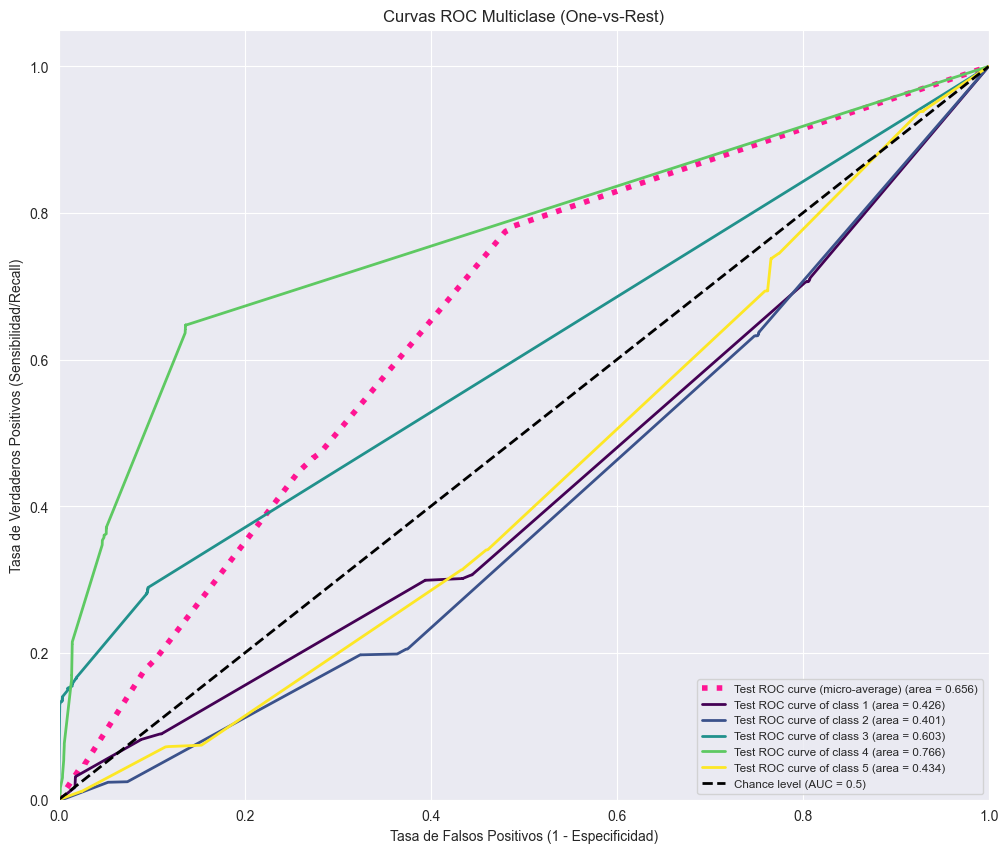

AUC ROC por clase (Prueba):
  Clase 1: 0.4257
  Clase 2: 0.4006
  Clase 3: 0.6028
  Clase 4: 0.7660
  Clase 5: 0.4345
AUC ROC Micro-Promediada (Prueba): 0.6563

AUC ROC por clase (Entrenamiento):
  Clase 1: 0.5822
  Clase 2: 0.5682
  Clase 3: 0.7997
  Clase 4: 0.8561
  Clase 5: 0.5803
AUC ROC Micro-Promediada (Entrenamiento): 0.7595


In [122]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np


# Clases del modelo (asegúrate de que sean las correctas, ej. [1, 2, 3, 4, 5])
classes = best_knn_model.classes_
n_classes = len(classes)

# --- Curvas ROC para el conjunto de ENTRENAMIENTO ---
# Binarizar las etiquetas de entrenamiento
y_train_binarized = label_binarize(y_train, classes=classes)

# Diccionarios para almacenar fpr, tpr y roc_auc para cada clase
fpr_train_dict = dict()
tpr_train_dict = dict()
roc_auc_train_dict = dict()

for i in range(n_classes):
    fpr_train_dict[i], tpr_train_dict[i], _ = roc_curve(y_train_binarized[:, i], y_proba_train[:, i])
    roc_auc_train_dict[i] = auc(fpr_train_dict[i], tpr_train_dict[i])

# Calcular la curva ROC micro-promediada y el área ROC para entrenamiento
fpr_train_micro, tpr_train_micro, _ = roc_curve(y_train_binarized.ravel(), y_proba_train.ravel())
roc_auc_train_micro = auc(fpr_train_micro, tpr_train_micro)

# --- Curvas ROC para el conjunto de PRUEBA ---
# Binarizar las etiquetas de prueba
y_test_binarized = label_binarize(y_test, classes=classes)

fpr_test_dict = dict()
tpr_test_dict = dict()
roc_auc_test_dict = dict()

for i in range(n_classes):
    fpr_test_dict[i], tpr_test_dict[i], _ = roc_curve(y_test_binarized[:, i], y_proba_test[:, i])
    roc_auc_test_dict[i] = auc(fpr_test_dict[i], tpr_test_dict[i])

# Calcular la curva ROC micro-promediada y el área ROC para prueba
fpr_test_micro, tpr_test_micro, _ = roc_curve(y_test_binarized.ravel(), y_proba_test.ravel())
roc_auc_test_micro = auc(fpr_test_micro, tpr_test_micro)


# --- Graficar las Curvas ROC ---
plt.figure(figsize=(12, 10))
lw = 2

# Graficar curva ROC micro-promediada de prueba
plt.plot(
    fpr_test_micro,
    tpr_test_micro,
    label=f"Test ROC curve (micro-average) (area = {roc_auc_test_micro:0.3f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)



# Imprimir AUCs para referencia
print("AUC ROC por clase (Prueba):")
for i in range(n_classes):
    print(f"  Clase {classes[i]}: {roc_auc_test_dict[i]:.4f}")
print(f"AUC ROC Micro-Promediada (Prueba): {roc_auc_test_micro:.4f}")

print("\nAUC ROC por clase (Entrenamiento):")
for i in range(n_classes):
    print(f"  Clase {classes[i]}: {roc_auc_train_dict[i]:.4f}")
print(f"AUC ROC Micro-Promediada (Entrenamiento): {roc_auc_train_micro:.4f}")

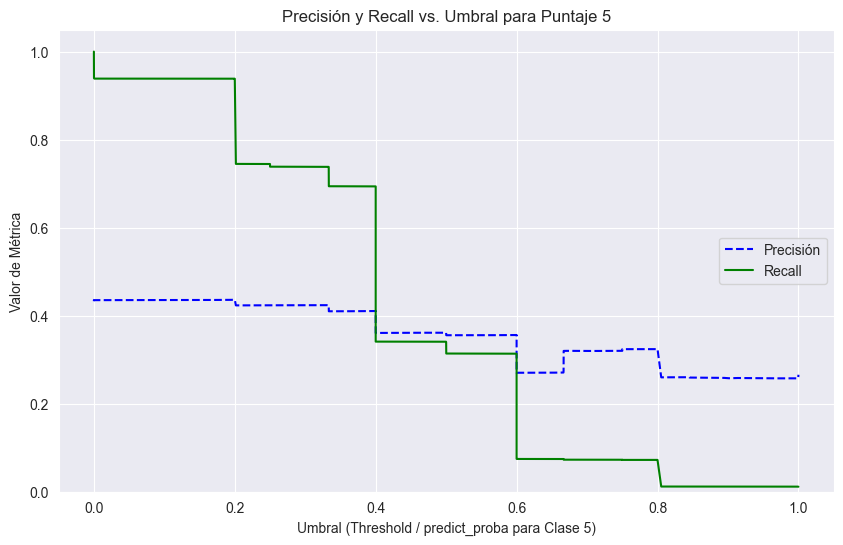


Para Puntaje 5:
  Umbral aproximado donde Precisión y Recall se cruzan: 0.4000
  Con Precisión: 0.3605 y Recall: 0.3408
  Umbral que maximiza F1-score: 0.0000
  Con Precisión: 0.4328, Recall: 1.0000, F1-score: 0.6041


In [123]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve

# Asumimos que ya tienes:
# best_knn_model: Tu modelo KNN entrenado y optimizado.
# X_test: Tus datos de prueba.
# y_test: Las etiquetas verdaderas de tu conjunto de prueba.
# y_proba_test = best_knn_model.predict_proba(X_test): Las probabilidades predichas.

# Elige la clase para la cual quieres visualizar este gráfico
# Por ejemplo, para "Puntaje 5"
clase_objetivo = 5 # O cualquier otra clase que te interese (1, 2, 3, 4)

# Encuentra el índice de columna correspondiente a la clase objetivo en y_proba_test
# Esto depende del atributo .classes_ de tu clasificador
try:
    idx_clase_objetivo = np.where(best_knn_model.classes_ == clase_objetivo)[0][0]
except IndexError:
    print(f"Error: La clase {clase_objetivo} no se encontró en best_knn_model.classes_ ({best_knn_model.classes_})")
    # Aquí deberías detenerte o manejar el error
    exit()


# Binariza y_test para la clase objetivo (One-vs-Rest)
y_test_binarized_clase_objetivo = (y_test == clase_objetivo).astype(int)

# Obtén las probabilidades solo para la clase objetivo
y_scores_clase_objetivo = y_proba_test[:, idx_clase_objetivo]

# Calcula precisión, recall y umbrales para la clase objetivo
precision, recall, thresholds = precision_recall_curve(
    y_test_binarized_clase_objetivo,
    y_scores_clase_objetivo
)

# Graficar Precision y Recall vs. Threshold
# 'thresholds' tiene un elemento menos que 'precision' y 'recall'.
# La última precisión es 1 y el último recall es 0 (sin umbral, ninguna muestra se predice como positiva).
# Por lo general, se grafica precision[:-1] y recall[:-1] contra thresholds.

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], "b--", label="Precisión")
plt.plot(thresholds, recall[:-1], "g-", label="Recall")
plt.xlabel("Umbral (Threshold / predict_proba para Clase " + str(clase_objetivo) + ")")
plt.ylabel("Valor de Métrica")
plt.title(f"Precisión y Recall vs. Umbral para Puntaje {clase_objetivo}")
plt.legend(loc="center right") # O "best"
plt.grid(True)
plt.ylim([0, 1.05]) # Asegurar que el eje Y vaya de 0 a 1
# Podrías querer ajustar xlim también, por ejemplo, si la mayoría de la acción ocurre en un rango pequeño de umbrales.
# plt.xlim([min_threshold_de_interes, max_threshold_de_interes])
plt.show()

# Encontrar el umbral donde Precision y Recall se cruzan (o están más cerca)
# Esto es solo un ejemplo de un punto de interés, no necesariamente el "óptimo" para todos los casos.
idx_interseccion_aprox = np.argmin(np.abs(precision[:-1] - recall[:-1]))
umbral_interseccion = thresholds[idx_interseccion_aprox]
precision_en_interseccion = precision[idx_interseccion_aprox]
recall_en_interseccion = recall[idx_interseccion_aprox]

print(f"\nPara Puntaje {clase_objetivo}:")
print(f"  Umbral aproximado donde Precisión y Recall se cruzan: {umbral_interseccion:.4f}")
print(f"  Con Precisión: {precision_en_interseccion:.4f} y Recall: {recall_en_interseccion:.4f}")

# También puedes buscar el umbral que maximiza el F1-score
f1_scores = (2 * precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-9) # Evitar división por cero
optimal_idx_f1 = np.argmax(f1_scores)
optimal_threshold_f1 = thresholds[optimal_idx_f1]
optimal_f1 = f1_scores[optimal_idx_f1]
precision_en_f1_optimo = precision[optimal_idx_f1]
recall_en_f1_optimo = recall[optimal_idx_f1]

print(f"  Umbral que maximiza F1-score: {optimal_threshold_f1:.4f}")
print(f"  Con Precisión: {precision_en_f1_optimo:.4f}, Recall: {recall_en_f1_optimo:.4f}, F1-score: {optimal_f1:.4f}")

Generando gráficos de Precisión y Recall vs. Umbral por clase...
  Gráfico para Puntaje 1 generado.
  Gráfico para Puntaje 2 generado.
  Gráfico para Puntaje 3 generado.
  Gráfico para Puntaje 4 generado.
  Gráfico para Puntaje 5 generado.


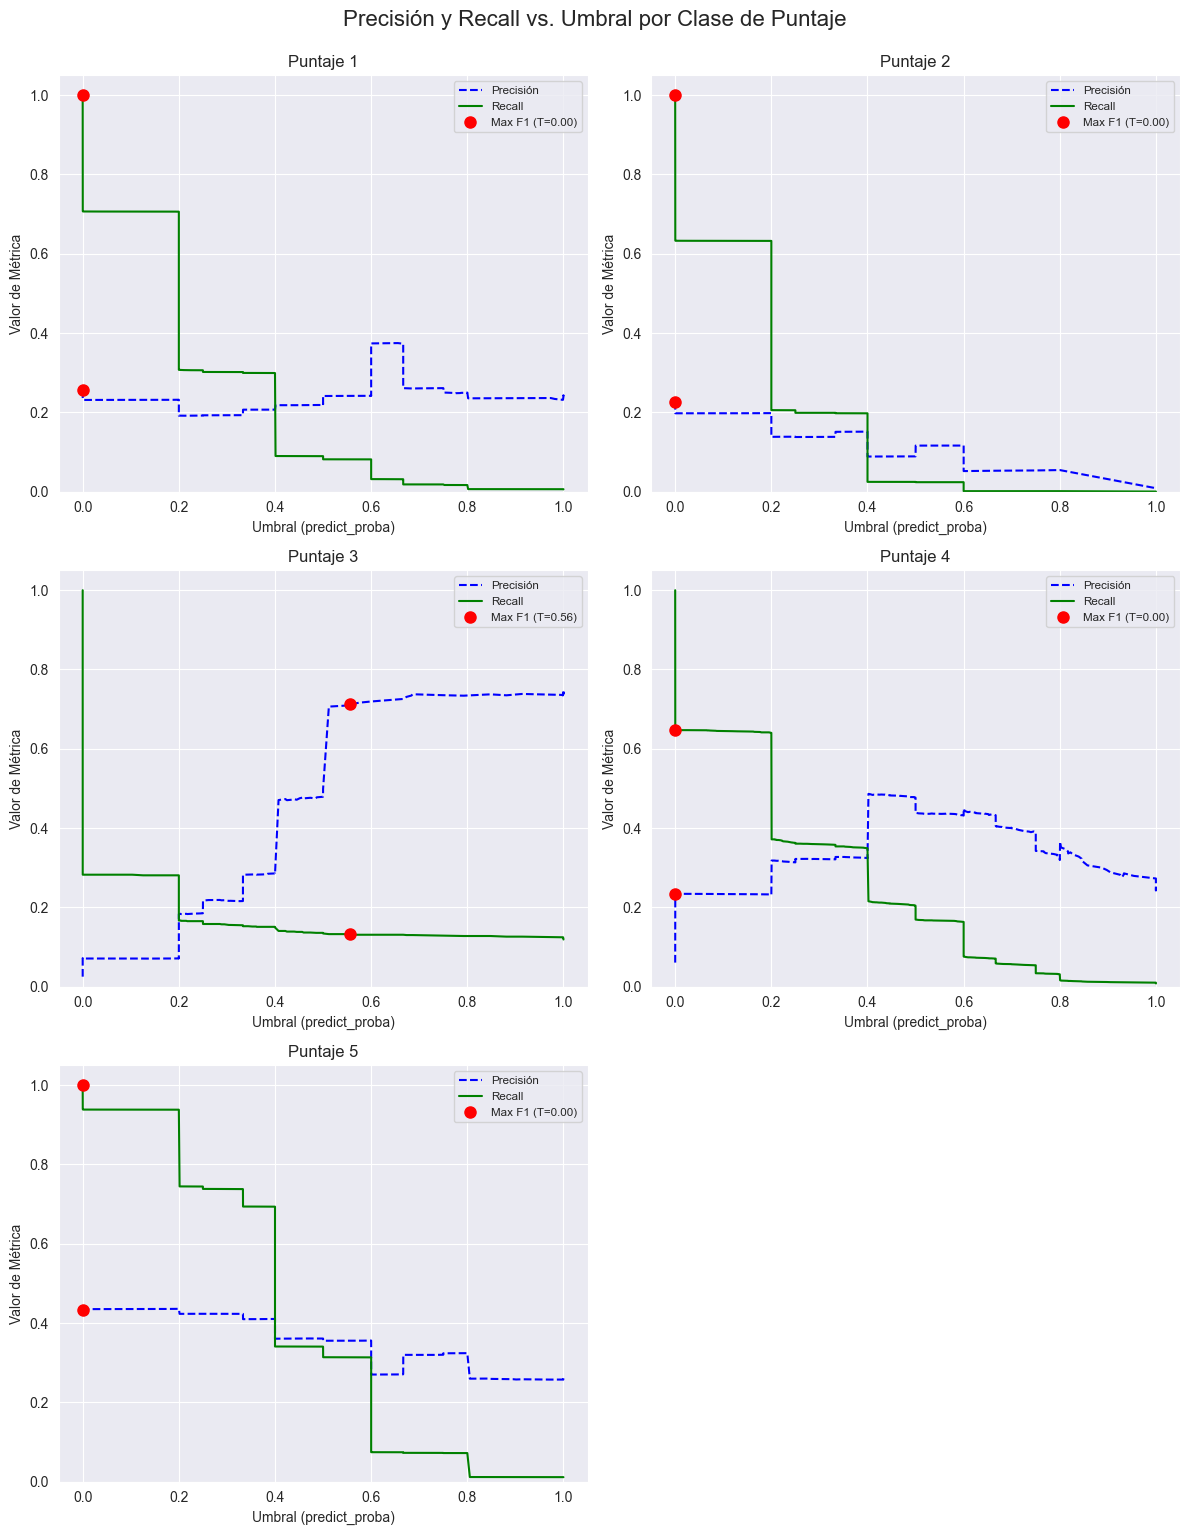


Análisis de umbrales completado.


In [124]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve

# Asumimos que ya tienes:
# best_knn_model: Tu modelo KNN entrenado y optimizado.
# X_test: Tus datos de prueba.
# y_test: Las etiquetas verdaderas de tu conjunto de prueba.
# y_proba_test = best_knn_model.predict_proba(X_test): Las probabilidades predichas.

# Clases (puntajes) que tiene tu modelo
# Asegúrate de que esto coincida con best_knn_model.classes_
# Por ejemplo, si tus clases son [1, 2, 3, 4, 5]
clases_del_modelo = sorted(np.unique(y_test)) # O directamente best_knn_model.classes_
if not np.array_equal(np.sort(best_knn_model.classes_), np.sort(clases_del_modelo)):
    print("Advertencia: best_knn_model.classes_ no coincide con las clases únicas en y_test.")
    print(f"best_knn_model.classes_: {best_knn_model.classes_}")
    print(f"Clases en y_test: {clases_del_modelo}")
    # Podrías querer usar best_knn_model.classes_ como la fuente autoritativa
    clases_del_modelo = best_knn_model.classes_


n_cols = 2
n_rows = 3 # Suficiente para 5 clases (2*3 = 6 plots)

# Crear la figura y los ejes para los subgráficos
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 15)) # Ajusta figsize según necesites
axes = axes.flatten() # Aplanar el array de ejes para iterar fácilmente

print("Generando gráficos de Precisión y Recall vs. Umbral por clase...")

for i, clase_objetivo in enumerate(clases_del_modelo):
    ax = axes[i] # Seleccionar el eje actual

    # Encuentra el índice de columna correspondiente a la clase objetivo en y_proba_test
    try:
        idx_clase_objetivo_en_proba = np.where(best_knn_model.classes_ == clase_objetivo)[0][0]
    except IndexError:
        print(f"Error: La clase {clase_objetivo} no se encontró en best_knn_model.classes_ ({best_knn_model.classes_}). Omitiendo este gráfico.")
        ax.set_title(f"Puntaje {clase_objetivo} (Datos no encontrados)")
        ax.axis('off') # Ocultar ejes si no hay datos
        continue

    # Binariza y_test para la clase objetivo (One-vs-Rest)
    y_test_binarized_clase_objetivo = (y_test == clase_objetivo).astype(int)

    # Obtén las probabilidades solo para la clase objetivo
    y_scores_clase_objetivo = y_proba_test[:, idx_clase_objetivo_en_proba]

    # Calcula precisión, recall y umbrales
    precision, recall, thresholds = precision_recall_curve(
        y_test_binarized_clase_objetivo,
        y_scores_clase_objetivo
    )

    # Graficar Precision y Recall vs. Threshold
    ax.plot(thresholds, precision[:-1], "b--", label="Precisión")
    ax.plot(thresholds, recall[:-1], "g-", label="Recall")
    ax.set_xlabel(f"Umbral (predict_proba)")
    ax.set_ylabel("Valor de Métrica")
    ax.set_title(f"Puntaje {clase_objetivo}")
    ax.legend(loc="best") # "center right" puede ser mejor si las curvas se superponen mucho
    ax.grid(True)
    ax.set_ylim([0, 1.05])

    # (Opcional) Encontrar y marcar puntos de interés en cada subgráfico
    # F1-score máximo
    f1_scores = (2 * precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-9)
    if len(f1_scores) > 0: # Asegurarse de que no esté vacío
        optimal_idx_f1 = np.argmax(f1_scores)
        optimal_threshold_f1 = thresholds[optimal_idx_f1]
        # Marcar el punto en el gráfico
        ax.plot(optimal_threshold_f1, precision[optimal_idx_f1], 'ro', markersize=8, label=f'Max F1 (T={optimal_threshold_f1:.2f})')
        ax.plot(optimal_threshold_f1, recall[optimal_idx_f1], 'ro', markersize=8)
        ax.legend(loc="best", fontsize='small') # Actualizar leyenda

    print(f"  Gráfico para Puntaje {clase_objetivo} generado.")

# Ocultar ejes de subgráficos no utilizados (si el número de clases es menor que n_rows*n_cols)
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j]) # O axes[j].axis('off')

plt.tight_layout() # Ajustar espaciado para evitar superposiciones de títulos/etiquetas
plt.suptitle("Precisión y Recall vs. Umbral por Clase de Puntaje", fontsize=16, y=1.02) # Título general
plt.show()

print("\nAnálisis de umbrales completado.")